# GNN recommender system

`wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip`

## MovieLens dataset

In [55]:
from pathlib import Path
import pandas as pd
import numpy as np

In [56]:
PATH = Path("ml-25m/")
#PATH = Path("/data2/yinterian/ml-latest-small/")
list(PATH.iterdir())

[PosixPath('ml-25m/genome-scores.csv'),
 PosixPath('ml-25m/movies.csv'),
 PosixPath('ml-25m/genome-tags.csv'),
 PosixPath('ml-25m/tags.csv'),
 PosixPath('ml-25m/README.txt'),
 PosixPath('ml-25m/links.csv'),
 PosixPath('ml-25m/original collaborative-filtering-nn.ipynb'),
 PosixPath('ml-25m/ratings.csv')]

In [57]:
data = pd.read_csv(PATH/"ratings.csv")

In [58]:
data

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


### Encoding data
We enconde the data to have contiguous ids for users and movies.   
You can think about this as a categorical encoding of our two categorical variables userId and movieId.

In [59]:
# split train and validation before encoding#
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train = data[msk].copy()
val = data[~msk].copy()

In [60]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [61]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [62]:
# encoding the train and validation data
df_train = encode_data(train)
df_val = encode_data(val, train)

In [63]:
train

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
6,1,1175,3.5,1147868826
...,...,...,...,...
25000088,162541,41566,4.0,1240952749
25000089,162541,45517,4.5,1240953353
25000091,162541,55768,2.5,1240951998
25000093,162541,58559,4.0,1240953434


In [64]:
df_train

,userId,movieId,rating,timestamp
0,0,0,5.0,1147880044
1,0,1,3.5,1147868817
2,0,2,5.0,1147868828
3,0,3,5.0,1147878820
6,0,4,3.5,1147868826
...,...,...,...,...
25000088,162540,420,4.0,1240952749
25000089,162540,430,4.5,1240953353
25000091,162540,4172,2.5,1240951998
25000093,162540,720,4.0,1240953434


## Embedding layer

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [66]:
num_users = len(df_train.userId.unique())
num_items = len(df_train.movieId.unique())
print(num_users, num_items) 

162541 56642


In [67]:
global train_losses
train_losses=[]
def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        global users,items,ratings
        users = torch.LongTensor(df_train.userId.values) # .cuda()
        items = torch.LongTensor(df_train.movieId.values) #.cuda()
        ratings = torch.FloatTensor(df_train.rating.values) #.cuda()
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("epochs : ",i) 
        print("train loss %.3f " % loss.item()) 
        validation_loss(model, unsqueeze)

In [68]:
# Here is what unsqueeze does
ratings = torch.FloatTensor(df_train.rating.values)
print(ratings.shape)
ratings = ratings.unsqueeze(1) # .cuda()
print(ratings.shape)

torch.Size([19999967])
torch.Size([19999967, 1])


In [69]:
import pandas as pd
global val_losses
val_losses=[]
def validation_loss(model, unsqueeze=False):
    model.eval()
    global users,items,ratings,y_hat
    users = torch.LongTensor(df_val.userId.values) #.cuda()
    items = torch.LongTensor(df_val.movieId.values) #.cuda()
    ratings = torch.FloatTensor(df_val.rating.values) #.cuda()
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
    y_hat = model(users, items)
    global df_users,df_items,df_y_hat,df_ratings
    df_users=pd.DataFrame(users.numpy())
    df_items=pd.DataFrame(items.numpy())
    df_y_hat=pd.DataFrame(y_hat.detach().numpy())
    df_ratings=pd.DataFrame(ratings.numpy())

    loss = F.mse_loss(y_hat, ratings)
    val_losses.append(loss)
    print("validation loss %.3f " % loss.item())

## Neural Network Model

In [70]:
# Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes.
# Here we could get better results by keep playing with regularization.
    
class CollabFNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=10):
        super(CollabFNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size*2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)
        
    def forward(self, u, v):
        global U,V
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.relu(torch.cat([U, V], dim=1))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [71]:
model = CollabFNet(num_users, num_items, emb_size=100) #.cuda()

In [72]:
train_epocs(model, epochs=30, lr=0.05, wd=1e-6, unsqueeze=True) 

epochs :  0
train loss 14.323 
validation loss 2.185 
epochs :  1
train loss 2.187 
validation loss 1.290 
epochs :  2
train loss 1.290 
validation loss 1.603 
epochs :  3
train loss 1.602 
validation loss 1.236 
epochs :  4
train loss 1.235 
validation loss 1.212 
epochs :  5
train loss 1.211 
validation loss 1.197 
epochs :  6
train loss 1.195 
validation loss 0.988 
epochs :  7
train loss 0.985 
validation loss 1.087 
epochs :  8
train loss 1.083 
validation loss 1.013 
epochs :  9
train loss 1.009 
validation loss 0.900 
epochs :  10
train loss 0.896 
validation loss 0.983 
epochs :  11
train loss 0.978 
validation loss 0.929 
epochs :  12
train loss 0.923 
validation loss 0.882 
epochs :  13
train loss 0.876 
validation loss 0.946 
epochs :  14
train loss 0.940 
validation loss 0.915 
epochs :  15
train loss 0.908 
validation loss 0.868 
epochs :  16
train loss 0.861 
validation loss 0.905 
epochs :  17
train loss 0.898 
validation loss 0.883 
epochs :  18
train loss 0.876 
valida

/home/kangjunekoo/anaconda3/envs/Pytorch2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kangjunekoo/anaconda3/envs/Pytorch2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

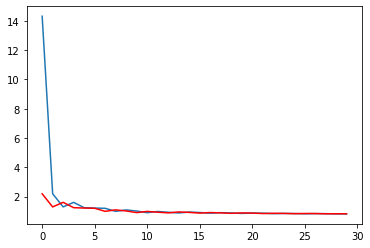

In [73]:
import seaborn as sns
train_losses_float=[float(train_loss.cpu().detach().numpy()) for train_loss in train_losses]
train_loss_indices=[i for i, l in enumerate(train_losses_float)]
plt=sns.lineplot(train_loss_indices,train_losses_float)
val_losses_float=[float(val_loss.cpu().detach().numpy()) for val_loss in val_losses]
val_loss_indices=[i for i, l in enumerate(val_losses_float)]
plt=sns.lineplot(val_loss_indices,val_losses_float,color='r')
plt

In [74]:
df_users.T

,0,1,2,3,4,5,6,7,8,9,...,4997311,4997312,4997313,4997314,4997315,4997316,4997317,4997318,4997319,4997320
0,0,0,0,0,0,0,0,0,1,1,...,162540,162540,162540,162540,162540,162540,162540,162540,162540,162540


In [75]:
df_items.T

,0,1,2,3,4,5,6,7,8,9,...,4997311,4997312,4997313,4997314,4997315,4997316,4997317,4997318,4997319,4997320
0,2018,1119,1567,3552,10649,8904,4143,18293,801,811,...,164,3465,356,364,1494,196,1683,1593,717,6542


In [76]:
df_y_hat.T

,0,1,2,3,4,5,6,7,8,9,...,4997311,4997312,4997313,4997314,4997315,4997316,4997317,4997318,4997319,4997320
0,4.189703,3.305351,4.279846,4.190954,3.07891,3.258963,3.195607,3.007886,3.873093,3.481153,...,3.979487,3.722397,2.958447,3.101805,3.641551,3.668627,3.57855,3.909931,3.62753,1.844123


In [77]:
df_ratings.T

,0,1,2,3,4,5,6,7,8,9,...,4997311,4997312,4997313,4997314,4997315,4997316,4997317,4997318,4997319,4997320
0,3.5,4.0,4.5,4.0,2.0,5.0,2.0,3.5,4.5,3.5,...,5.0,4.5,3.0,2.0,4.5,4.0,4.5,4.5,4.5,2.0


In [78]:
U

tensor([[-0.0253,  0.4130,  0.1812,  ...,  0.7823, -0.0777,  0.0757],
        [-0.0253,  0.4130,  0.1812,  ...,  0.7823, -0.0777,  0.0757],
        [-0.0253,  0.4130,  0.1812,  ...,  0.7823, -0.0777,  0.0757],
        ...,
        [-1.7156,  0.1468,  0.1019,  ..., -0.0342,  0.1744,  0.0628],
        [-1.7156,  0.1468,  0.1019,  ..., -0.0342,  0.1744,  0.0628],
        [-1.7156,  0.1468,  0.1019,  ..., -0.0342,  0.1744,  0.0628]],
       grad_fn=<EmbeddingBackward0>)

In [79]:
df_U=U.detach().numpy()
df_U=pd.DataFrame(df_U)
df_U=df_U.drop_duplicates(keep='last')
df_U=df_U.reset_index(drop=True)
df_User=df_U

In [80]:
df_User

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.025289,0.413023,0.181197,0.058171,0.045377,0.039454,0.264918,0.102843,-0.047593,0.052350,...,0.086936,0.093123,0.050382,-0.051555,0.076521,-0.032185,-0.145358,0.782276,-0.077669,0.075736
1,-0.522029,0.137147,0.054206,0.132019,0.171533,-0.023574,0.096437,0.093175,-0.005525,0.676545,...,0.112071,0.270260,0.223946,-0.037249,0.100159,0.202360,0.126440,0.058639,-0.032221,0.102653
2,0.254711,0.251521,0.114389,0.107864,-0.002842,-0.487601,0.173444,0.044555,-0.358866,0.019072,...,0.285851,0.082105,0.155496,0.131218,0.057988,-0.243605,0.004778,-0.056618,0.526010,0.194906
3,-0.088618,-0.031766,0.037517,0.558551,0.097956,-0.016636,0.002942,-0.005102,-0.074375,0.001738,...,-0.299114,-0.098712,0.079092,0.122044,0.035592,-0.375502,0.095573,0.119794,0.029397,-0.379515
4,-0.047346,0.105215,0.017723,0.174631,0.044606,-0.059841,0.206474,-0.141643,0.129780,-0.040136,...,0.095193,-0.164458,0.134954,0.092161,0.107317,0.030282,-0.031486,0.080290,-0.024301,0.233056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162358,0.212426,0.198345,0.123471,0.197258,0.284258,0.344386,0.090592,0.065817,0.227398,0.077869,...,0.190388,0.644494,0.133566,-0.013868,0.406369,0.128966,0.243120,0.077813,0.159205,0.207871
162359,-0.136835,0.017742,0.111226,0.064649,-0.143403,0.021534,0.004072,-0.010846,0.130207,0.211785,...,0.071664,-0.050675,0.090894,0.046595,0.096289,-0.014474,0.591228,-0.003275,0.085392,0.111765
162360,0.136957,0.268261,0.142449,0.083437,0.169006,0.353735,0.101220,0.163294,0.166790,0.290311,...,0.157516,0.149429,0.363447,0.151899,0.167534,-0.386263,0.103196,0.079383,0.572249,0.167654
162361,0.295827,0.116508,0.092065,0.032320,-0.042698,0.194767,0.025974,0.192930,0.047745,1.465358,...,0.157536,0.143530,0.107331,0.328806,0.149480,0.181593,-0.018424,0.143527,0.083596,0.192254


In [81]:
df_V=V.detach().numpy()
df_V=pd.DataFrame(df_V)
df_V=df_V.drop_duplicates(keep='last')
df_V=df_V.reset_index(drop=True)
df_Movie=df_V

In [82]:
df_Movie

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.086305,0.137480,-0.112218,0.044766,0.009932,0.077229,-0.047859,0.078506,0.123891,0.140803,...,0.179150,-0.008513,0.108616,-0.051338,-0.082237,-0.088463,0.190236,0.181162,0.049896,0.849993
1,0.170017,0.069945,0.084344,0.139637,-0.124059,0.032607,0.860541,-0.017691,0.049370,-0.064749,...,-0.118995,0.060148,0.045980,-0.331832,0.361993,0.046436,0.327406,0.048488,0.156992,0.082864
2,0.015559,-0.055364,-0.017910,-0.118827,-0.037649,0.001317,0.010491,-0.021699,0.060204,-0.744566,...,-0.132111,-0.082345,0.134799,-1.232290,-0.393547,-0.012809,0.071473,0.014830,-0.026010,-0.039559
3,-0.733041,-0.837699,-0.128343,0.102128,0.113312,0.143954,-0.149878,0.008742,0.143708,0.092271,...,0.032558,0.285256,0.001874,-0.131580,0.027654,-0.066563,0.026620,0.800927,0.025885,-0.001177
4,0.028636,-0.010271,-0.033905,0.488397,0.109334,0.048682,-0.008071,0.152968,0.067577,0.029869,...,0.023017,-0.134068,0.014559,-0.085333,-0.113545,0.018109,-0.091716,-0.026151,-0.065127,0.119989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37138,1.373825,-0.277734,1.245589,-0.132247,-0.366304,-0.266475,-0.396574,0.166938,-0.105668,-0.237593,...,0.007117,-0.574751,0.064671,0.386744,-0.018510,-1.174899,-0.215111,-0.196357,0.693477,-0.187612
37139,-0.012548,0.172854,0.512848,-0.055655,0.378153,0.843139,0.199872,-0.408515,0.424936,1.027087,...,0.178935,2.254689,-0.115275,0.150886,-0.189406,0.238395,-0.153499,1.446406,0.573964,0.362155
37140,1.548182,0.103375,2.578741,1.153093,-0.158213,-0.078494,-0.230421,0.893290,-0.017003,0.435000,...,-0.000519,0.882258,-0.208264,0.860942,-1.762629,-0.167798,1.610019,0.290709,-0.416267,0.228376
37141,1.809607,0.036789,1.670637,-0.237437,-0.194331,-0.208337,0.973582,-0.010370,0.201885,0.258293,...,0.904033,0.567535,1.324677,0.366024,-0.158258,1.767282,1.946356,-0.185399,0.450016,0.004655


In [83]:
num_users

162541

In [84]:
num_items

56642